In [38]:
from itertools import product # combinatorics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as ss # statistical functions
import matplotlib.pyplot as plt # plotting
import seaborn as sns # pretty plots
import math # math functions
import warnings # clear warnings

from collections import Counter
from sklearn.model_selection import train_test_split # data splitting

import tensorflow as tf  # building NN model
from tensorflow.keras.layers.experimental import preprocessing # input preprocessing
from sklearn.preprocessing import StandardScaler
# model evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score, f1_score,confusion_matrix

warnings.filterwarnings('ignore')

### Reading the files

#### USPs

In [39]:
# Reading the usp text file as a csv file with the delimiter \t(tab) 
usp_data = pd.read_csv('data/usp.txt', delimiter='\t', header=None)
# Renaming the column and adding a new column as a label
usp_data.rename(columns={0:'sequence'}, inplace=True)
usp_data['label'] = 'usp'
usp_data.head()

,sequence,label
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp


#### Non-USPs

In [40]:
# Reading the usp text file as a csv file with the delimiter \t(tab) 
non_usp_data = pd.read_csv('data/non_usp.txt', delimiter='\t', header=None)
# Renaming the column and adding a new column as a label
non_usp_data.rename(columns={0:'sequence'}, inplace=True)
non_usp_data['label'] = 'non_usp'
non_usp_data.head()

,sequence,label
0,MSTTEFPTTTKRLMGWGRTAPTVASVLSTSDPEVIVRAVTRAAEEG...,non_usp
1,MAISGVPVLGFFIIAVLMSAQESWAIKEEHVIIQAEFYLNPDQSGE...,non_usp
2,MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHF...,non_usp
3,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,non_usp
4,MPELPEVETSRRGIEPHLVGATILHAVVRNGRLRWPVSEEIYRLSD...,non_usp


### Merging the two data together vertically

In [41]:
df = pd.concat([usp_data, non_usp_data], ignore_index=True)
df.sample(5)

,sequence,label
587,MTQVXVFDIGLNKAMIAARRIAELDPYLAVDLVTSGLSPESVDEFL...,non_usp
323,MSDHFTFADRHIGLDSPAVTKMLDVIGVGSLDELAAKAVPSGILDK...,non_usp
93,MTVISRGRRTGVQPASRFSWVPAAAGWIVGVIATLSLIASVSPAVR...,non_usp
158,MAAMNTDAAVLAKEAANFERISGELKGVIAQVESTGSALAAQMVGQ...,non_usp
21,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp


In [42]:
df['sequence'][0]

'MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPPVITAPEGWAFEYSRFQEAQKREIVEHSYLVAQAHQIVEQAHKVALEASSSGRAAQITGEVLHGQIVPTLTNISRQVAMVVLGYRGQGAVAGALLGSVSSSLVRHAHGPVAVIPEEPRPARPPHAPVVVGIDGSPTSGLAAEIAFDEASRRGVDLVALHAWSDMGPLDFPRLNWAPIEWRNLEDEQEKMLARRLSGWQDRYPDVVVHKVVVCDRPAPRLLELAQTAQLVVVGSHGRGGFPGMHLGSVSRAVVNSGQAPVIVARIPQDPAVPA'

#### Checking the uniqueness of the sequence

In [43]:
alpha = np.unique(list(df['sequence'][0]))
alpha

array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype='<U1')

In [44]:
df['sequence'][0].count('A')/len(df['sequence'][0])

0.12618296529968454

#### Converting the label from usp and non_usp into 1 and 0

In [45]:
df['target'] = df['label'].apply(lambda x: 1 if x == 'usp' else 0)

In [46]:
df['target'].unique()

array([1, 0], dtype=int64)

#### Creating a column for each of the alphabets

In [47]:
for letter in alpha:
    df[letter] = 0

In [48]:
df.head()

,sequence,label,target,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Creating a column each for the di- alphabets
    using product from itertools
    and merging with the mono alphabets

In [49]:
# This was hardcoded to remove unnecesary characters
# that might make it hard to access each column
combos = product(alpha, repeat=2)
for combo in combos:
    df[str(combo).replace(',', '').replace("'",'').replace(' ', '').replace(')', '').replace('(', '')] = 0

In [50]:
df

,sequence,label,target,A,C,D,E,F,G,H,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,MTRAGDDAVNLTLVTGAPANGGSCVAHHEGRVVFVRYALPGERVRA...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
655,MGAQGYLRRLTRRLTEDLEQRDVEELSDEVLNAGAQRAIDCQRGQE...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
656,MFESLSDRLTAALQGLRGKGRLTDADIDATTREIRLALLEADVSLP...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,MTEALIPAPSQISLTRDEVRRYSRHLIIPDIGVNGQQRLKDARVLC...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
non_alpha = ['sequence', 'label','target']
columns = df.columns
columns = [column for column in columns if column not in non_alpha]
len(columns)

420

### Calculating the values to be inserted in the mono alphabets and di alphabets
    creating a function for calculating the value

In [52]:
for column in columns:
    df[column] = df['sequence'].apply(lambda x: x.count(column)/len(x))


In [53]:
df.head()

,sequence,label,target,A,C,D,E,F,G,H,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0.126183,0.006309,0.037855,0.056782,0.015773,0.082019,0.037855,...,0.0,0.0,0.003155,0.0,0.003155,0.003155,0.000000,0.0,0.0,0.0
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp,1,0.116438,0.010274,0.037671,0.054795,0.013699,0.078767,0.030822,...,0.0,0.0,0.003425,0.0,0.003425,0.006849,0.003425,0.0,0.0,0.0
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0.129338,0.006309,0.037855,0.056782,0.015773,0.082019,0.037855,...,0.0,0.0,0.003155,0.0,0.003155,0.003155,0.000000,0.0,0.0,0.0
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp,1,0.125424,0.010169,0.050847,0.061017,0.010169,0.081356,0.023729,...,0.0,0.0,0.006780,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp,1,0.117845,0.006734,0.057239,0.053872,0.003367,0.077441,0.030303,...,0.0,0.0,0.003367,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [54]:
df.columns = df.columns.astype(str)

### Doing some analyses
    - correlation of the variables
    - relationship of the variables with the outcome/label

In [55]:
label = df.pop('label')
target = df.pop('target')

In [56]:
text = df.pop('sequence')

In [57]:
mono_col = alpha
di_col = [col for col in df.columns if col not in mono_col]

In [58]:
# analysis of mono_alpha(singular alphabets) features
numerical_data = df[mono_col]
# summary statistics for numerical features
numerical_data.describe()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,0.110534,0.010132,0.061132,0.057090,0.026298,0.089055,0.021917,0.045576,0.038916,0.084770,0.020162,0.024205,0.057840,0.032159,0.076566,0.055450,0.056322,0.095586,0.012344,0.021276
std,0.037156,0.014086,0.024070,0.023890,0.016228,0.026520,0.013094,0.017981,0.030904,0.028895,0.009195,0.012646,0.022718,0.015355,0.030447,0.020467,0.020771,0.028093,0.012107,0.012416
min,0.026549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086896,0.000000,0.045455,0.040816,0.015000,0.074830,0.013605,0.034139,0.017544,0.065615,0.014265,0.015802,0.044248,0.021894,0.057524,0.041625,0.043573,0.076059,0.004525,0.012618
50%,0.108844,0.006211,0.061224,0.054645,0.025000,0.085973,0.020665,0.043103,0.029412,0.083333,0.019048,0.023762,0.055130,0.030303,0.072555,0.054945,0.054745,0.095238,0.010949,0.020704
75%,0.128802,0.012766,0.072858,0.069884,0.034952,0.101554,0.029240,0.055970,0.053126,0.102115,0.025573,0.031674,0.066909,0.040000,0.091874,0.068790,0.068467,0.110000,0.017544,0.028026
max,0.309278,0.081633,0.181818,0.181818,0.100000,0.222222,0.097087,0.117647,0.203540,0.216667,0.066667,0.081633,0.147887,0.093750,0.222222,0.148872,0.132530,0.217391,0.181818,0.090909


In [59]:
numerical_data2 = df[di_col]
numerical_data2.describe()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,...,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,0.013059,0.000825,0.006688,0.006689,0.002293,0.009859,0.002452,0.004738,0.005211,0.009336,...,0.000121,0.000408,0.001453,0.000561,0.001870,0.000922,0.001486,0.001692,0.000227,0.000624
std,0.011530,0.002735,0.006822,0.006114,0.003352,0.007860,0.003836,0.005275,0.007733,0.007899,...,0.000612,0.001481,0.002390,0.001525,0.003148,0.002125,0.003664,0.002968,0.000982,0.001756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006552,0.000000,0.000000,0.001876,0.000000,0.003401,0.000000,0.000000,0.000000,0.003401,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011111,0.000000,0.005618,0.005714,0.000000,0.009346,0.000000,0.003843,0.003546,0.008547,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.017012,0.000000,0.010174,0.010169,0.003731,0.014035,0.003425,0.007356,0.006842,0.013875,...,0.000000,0.000000,0.002729,0.000000,0.003048,0.000000,0.000917,0.002829,0.000000,0.000000
max,0.103093,0.020408,0.050000,0.033333,0.030928,0.045714,0.027778,0.048387,0.066372,0.051852,...,0.007782,0.016667,0.014815,0.014599,0.017751,0.014925,0.037037,0.018182,0.008772,0.016667


In [60]:
columns = ['A','C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'AA',
 'AC',
 'AD',
 'AE',
 'AF',
 'AG',
 'AH',
 'AI',
 'AK',
 'AL',
 'AM',
 'AN',
 'AP',
 'AQ',
 'AR',
 'AS',
 'AT',
 'AV',
 'AW',
 'AY',
 'CA',
 'CC',
 'CD',
 'CE',
 'CF',
 'CG',
 'CH',
 'CI',
 'CK',
 'CL',
 'CM',
 'CN',
 'CP',
 'CQ',
 'CR',
 'CS',
 'CT',
 'CV',
 'CW',
 'CY',
 'DA',
 'DC',
 'DD',
 'DE',
 'DF',
 'DG',
 'DH',
 'DI',
 'DK',
 'DL',
 'DM',
 'DN',
 'DP',
 'DQ',
 'DR',
 'DS',
 'DT',
 'DV',
 'DW',
 'DY',
 'EA',
 'EC',
 'ED',
 'EE',
 'EF',
 'EG',
 'EH',
 'EI',
 'EK',
 'EL',
 'EM',
 'EN',
 'EP',
 'EQ',
 'ER',
 'ES',
 'ET',
 'EV',
 'EW',
 'EY',
 'FA',
 'FC',
 'FD',
 'FE',
 'FF',
 'FG',
 'FH',
 'FI',
 'FK',
 'FL',
 'FM',
 'FN',
 'FP',
 'FQ',
 'FR',
 'FS',
 'FT',
 'FV',
 'FW',
 'FY',
 'GA',
 'GC',
 'GD',
 'GE',
 'GF',
 'GG',
 'GH',
 'GI',
 'GK',
 'GL',
 'GM',
 'GN',
 'GP',
 'GQ',
 'GR',
 'GS',
 'GT',
 'GV',
 'GW',
 'GY',
 'HA',
 'HC',
 'HD',
 'HE',
 'HF',
 'HG',
 'HH',
 'HI',
 'HK',
 'HL',
 'HM',
 'HN',
 'HP',
 'HQ',
 'HR',
 'HS',
 'HT',
 'HV',
 'HW',
 'HY',
 'IA',
 'IC',
 'ID',
 'IE',
 'IF',
 'IG',
 'IH',
 'II',
 'IK',
 'IL',
 'IM',
 'IN',
 'IP',
 'IQ',
 'IR',
 'IS',
 'IT',
 'IV',
 'IW',
 'IY',
 'KA',
 'KC',
 'KD',
 'KE',
 'KF',
 'KG',
 'KH',
 'KI',
 'KK',
 'KL',
 'KM',
 'KN',
 'KP',
 'KQ',
 'KR',
 'KS',
 'KT',
 'KV',
 'KW',
 'KY',
 'LA',
 'LC',
 'LD',
 'LE',
 'LF',
 'LG',
 'LH',
 'LI',
 'LK',
 'LL',
 'LM',
 'LN',
 'LP',
 'LQ',
 'LR',
 'LS',
 'LT',
 'LV',
 'LW',
 'LY',
 'MA',
 'MC',
 'MD',
 'ME',
 'MF',
 'MG',
 'MH',
 'MI',
 'MK',
 'ML',
 'MM',
 'MN',
 'MP',
 'MQ',
 'MR',
 'MS',
 'MT',
 'MV',
 'MW',
 'MY',
 'NA',
 'NC',
 'ND',
 'NE',
 'NF',
 'NG',
 'NH',
 'NI',
 'NK',
 'NL',
 'NM',
 'NN',
 'NP',
 'NQ',
 'NR',
 'NS',
 'NT',
 'NV',
 'NW',
 'NY',
 'PA',
 'PC',
 'PD',
 'PE',
 'PF',
 'PG',
 'PH',
 'PI',
 'PK',
 'PL',
 'PM',
 'PN',
 'PP',
 'PQ',
 'PR',
 'PS',
 'PT',
 'PV',
 'PW',
 'PY',
 'QA',
 'QC',
 'QD',
 'QE',
 'QF',
 'QG',
 'QH',
 'QI',
 'QK',
 'QL',
 'QM',
 'QN',
 'QP',
 'QQ',
 'QR',
 'QS',
 'QT',
 'QV',
 'QW',
 'QY',
 'RA',
 'RC',
 'RD',
 'RE',
 'RF',
 'RG',
 'RH',
 'RI',
 'RK',
 'RL',
 'RM',
 'RN',
 'RP',
 'RQ',
 'RR',
 'RS',
 'RT',
 'RV',
 'RW',
 'RY',
 'SA',
 'SC',
 'SD',
 'SE',
 'SF',
 'SG',
 'SH',
 'SI',
 'SK',
 'SL',
 'SM',
 'SN',
 'SP',
 'SQ',
 'SR',
 'SS',
 'ST',
 'SV',
 'SW',
 'SY',
 'TA',
 'TC',
 'TD',
 'TE',
 'TF',
 'TG',
 'TH',
 'TI',
 'TK',
 'TL',
 'TM',
 'TN',
 'TP',
 'TQ',
 'TR',
 'TS',
 'TT',
 'TV',
 'TW',
 'TY',
 'VA',
 'VC',
 'VD',
 'VE',
 'VF',
 'VG',
 'VH',
 'VI',
 'VK',
 'VL',
 'VM',
 'VN',
 'VP',
 'VQ',
 'VR',
 'VS',
 'VT',
 'VV',
 'VW',
 'VY',
 'WA',
 'WC',
 'WD',
 'WE',
 'WF',
 'WG',
 'WH',
 'WI',
 'WK',
 'WL',
 'WM',
 'WN',
 'WP',
 'WQ',
 'WR',
 'WS',
 'WT',
 'WV',
 'WW',
 'WY',
 'YA',
 'YC',
 'YD',
 'YE',
 'YF',
 'YG',
 'YH',
 'YI',
 'YK',
 'YL',
 'YM',
 'YN',
 'YP',
 'YQ',
 'YR',
 'YS',
 'YT',
 'YV',
 'YW',
 'YY']

df = df[columns]

In [61]:
target

0      1
1      1
2      1
3      1
4      1
      ..
654    0
655    0
656    0
657    0
658    0
Name: target, Length: 659, dtype: int64

In [62]:
ssc = StandardScaler()
ssc.fit(df[columns])
df[columns] = ssc.transform(df[columns])
print('fitted_training features:')
df

fitted_training features:


,A,C,D,E,F,G,H,I,K,L,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,0.421499,-0.271597,-0.967806,-0.012877,-0.649037,-0.265511,1.218124,-0.254139,-0.851595,-0.423056,...,-0.197597,-0.275688,0.712295,-0.368062,0.408371,1.051874,-0.405890,-0.570599,-0.231843,-0.355262
1,0.159038,0.010081,-0.975442,-0.096146,-0.776951,-0.388221,0.680602,-0.630548,-0.816611,0.859587,...,-0.197597,-0.275688,0.825372,-0.368062,0.494232,2.792273,0.529453,-0.570599,-0.231843,-0.355262
2,0.506464,-0.271597,-0.967806,-0.012877,-0.649037,-0.265511,1.218124,-0.254139,-0.851595,-0.423056,...,-0.197597,-0.275688,0.712295,-0.368062,0.408371,1.051874,-0.405890,-0.570599,-0.231843,-0.355262
3,0.401050,0.002658,-0.427612,0.164511,-0.994584,-0.290530,0.138485,-1.027274,-0.382036,-0.118248,...,-0.197597,-0.275688,2.230021,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
4,0.196928,-0.241414,-0.161867,-0.134788,-1.414077,-0.438261,0.640944,-0.287836,-0.933112,0.329233,...,-0.197597,-0.275688,0.801233,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,0.946604,0.683517,0.230106,-0.529709,-0.251321,0.645960,0.966903,-1.299799,-0.940380,-0.028383,...,-0.197597,-0.275688,-0.608440,-0.368062,0.190466,0.729000,-0.405890,1.094507,2.285484,-0.355262
655,-1.652485,0.444834,-0.156130,1.042115,-1.116240,1.588404,-1.048614,-0.255578,-0.463915,0.754588,...,-0.197597,5.264784,-0.608440,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
656,0.421824,-0.040627,0.002213,0.091475,0.500691,0.824293,-0.944403,0.123873,0.659220,0.573833,...,-0.197597,-0.275688,-0.608440,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
657,-0.415265,1.106505,0.237231,-0.345446,-0.670541,0.034692,0.486146,2.184986,-0.344505,0.714449,...,-0.197597,-0.275688,-0.608440,-0.368062,1.857232,0.776839,-0.405890,0.296198,-0.231843,-0.355262


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Columns: 420 entries, A to YY
dtypes: float64(420)
memory usage: 2.1 MB


#### Getting the correlation between the singular group/mono_alphabets part of the sequence
    - This helps is selecting the useful features from the huge columns we have
    

    MONO-ALPHABETS

In [64]:
# calculate point biserial coefficient between numerical(mono alphabets) features and the target variable

rpb_scores_mono = dict()

for feature in mono_col:
    y = numerical_data[feature]
    rpb = abs(ss.stats.pointbiserialr(y,target).correlation)
    rpb_scores_mono[feature] = rpb
    
# sort the scores in descending order
rpb_scores_mono = sorted(rpb_scores_mono.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
for k,v in rpb_scores_mono:
    print("{} : {}".format(k,v))

V : 0.35299030551311283
T : 0.3299375467231308
F : 0.32745303260376796
S : 0.2889068321801659
H : 0.25634977598141373
A : 0.23471509838546756
N : 0.18433356353331845
K : 0.16935214723401792
Y : 0.14978221912190992
D : 0.10718609705976613
W : 0.10396009061591244
G : 0.10023183419824688
M : 0.09478474078228466
I : 0.07974936940093644
Q : 0.06923718831419089
R : 0.020599411718022063
L : 0.014582889830924253
E : 0.014452939947387734
C : 0.014086731140724578
P : 0.003811848744872783


### Plotting the graph of the top 20 mono features with the highest correlation to the target variable

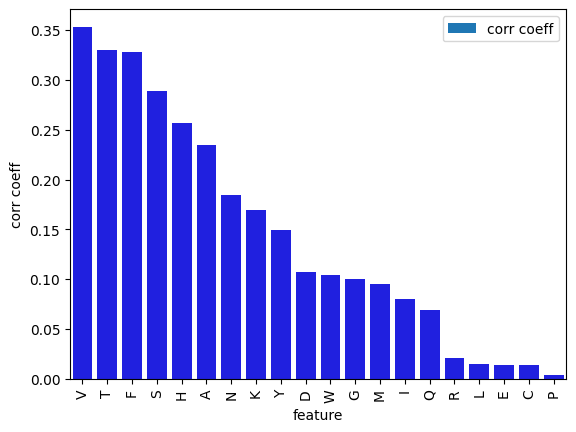

In [65]:
data_mono = pd.DataFrame(rpb_scores_mono, columns=['feature', 'corr coeff'])
data_mono[0:20].plot(kind='bar')
sns.barplot(data = data_mono[0:20], x='feature', y='corr coeff', color='blue')
# plt.xlabel(data['feature'][0:20])
plt.savefig('mono_alpha.jpg')

    The chart above shows the relationship or the correlation between the different features(Mono-Alphabets/ Singular alphabets) and the outcome of the data:
        USPs
        Non-USPs
    This correlation was gotten by using the scipy stats pointbiserial function.
    From the chart, it can be seen that the mono-alphabets we have are:
        A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y
        20 alphabets.
        in order of their correlation value.

    BI-ALPHABETS

In [66]:
# calculate point biserial coefficient between numerical(bi alphabets) features and the target variable

rpb_scores_bi = dict()

for feature in di_col:
    y = numerical_data2[feature]
    rpb = abs(ss.stats.pointbiserialr(y,target).correlation)
    rpb_scores_bi[feature] = rpb
    
# sort the scores in descending order
rpb_scores_bi = sorted(rpb_scores_bi.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
for k,v in rpb_scores_bi:
    print("{} : {}".format(k,v))

GS : 0.4988210855522441
WQ : 0.4218265057336953
HA : 0.38376443590503734
PV : 0.36609603482338454
VG : 0.3644740968721593
VV : 0.31266576490790193
VH : 0.2874920496450957
MS : 0.27866497852743
LV : 0.2782363080391816
WP : 0.27814213289076345
WA : 0.276294332780257
AV : 0.27621776688399746
EA : 0.2759735037018608
YP : 0.26853122290553705
LH : 0.26530128124355196
GD : 0.2513567764669557
SA : 0.24270063135641756
SH : 0.2400620120120587
AH : 0.23259859377165476
AQ : 0.23123083307849407
SV : 0.22658946209138986
SR : 0.21182718178241522
GW : 0.21071346452924475
RT : 0.20871750243544282
DT : 0.20828221544224423
QQ : 0.20517882458069922
IV : 0.20395686855267783
VT : 0.2020830720464976
SS : 0.20158997226345002
FG : 0.19422169718008278
HS : 0.19346498153970643
LA : 0.18937225578524663
EG : 0.18742367988981737
FA : 0.18623936430392835
AS : 0.17999177730330854
AR : 0.1796955789352605
NP : 0.1790272383405273
IR : 0.17881899696470746
TR : 0.17689940085458472
GK : 0.17598906108110315
RI : 0.169426293

#### Plotting the top 20 values of the bi alphabets with the highest correlation to the target variable

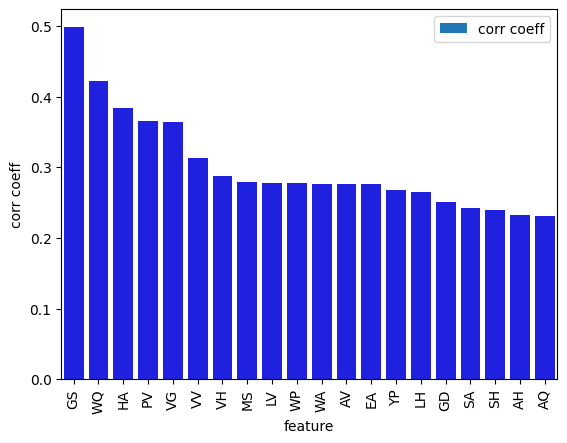

In [67]:
data_bi = pd.DataFrame(rpb_scores_bi, columns=['feature', 'corr coeff'])
data_bi[0:20].plot(kind='bar')
sns.barplot(data = data_bi[0:20], x='feature', y='corr coeff', color='blue')
plt.savefig('bi-alpha_corr.jpg')

    The chart above shows the relationship or the correlation between the different features(Bi-Alphabets/ Double alphabets) and the outcome of the data:
        USPs
        Non-USPs
    This correlation was gotten by using the scipy stats pointbiserial function.
    From the chart, it can be seen that the bi-alphabets we have are 400 in numbers:
        This is gotten from the product function in python which is combination of alphabets with repetition allowed i.e n^2. 
        20 of the highest were plotted above and in order of their correlation values.

### Building the model

    splitting the dataset into:
        train - 60
        val - 20
        test - 20

In [68]:
# splitting the data into train,test and validation
X_train, x_test, Y_train, y_test = train_test_split(df, target, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)
print(len(x_train), 'train examples')
print(len(x_val), 'validation examples')
print(len(x_test), 'test examples')

370 train examples
124 validation examples
165 test examples


### Using the Support vector machine

In [69]:
from sklearn.svm import SVC

model_svc = SVC()

model_svc.fit(x_train, y_train)

SVC()

In [70]:
y_pred_svc = model_svc.predict(x_test)
y_pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [71]:
print("accuracy:\n  {}".format(accuracy_score(y_pred_svc,y_test)))
print("\n")
print("classification report:\n {}".format(classification_report(y_pred_svc,y_test)))

accuracy:
  0.9939393939393939


classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       0.94      1.00      0.97        15

    accuracy                           0.99       165
   macro avg       0.97      1.00      0.98       165
weighted avg       0.99      0.99      0.99       165



    The classification report shows the report on important metrics like the precision, recall, and f1 score values.

    Precision:
        Precision measures the proportion of correctly predicted positive instances (true positives) out of all instances that the model predicted as positive (true positives + false positives).

        Mathematically, precision is defined as:

        Precision = True Positives/(True Positives + False Positives)
        ​
        High precision indicates that when the model predicts a positive class, it is usually correct. However, it doesn't account for instances that were incorrectly predicted as negative.

    Recall (Sensitivity or True Positive Rate):
        Recall measures the proportion of correctly predicted positive instances (true positives) out of all actual positive instances (true positives + false negatives). It answers the question: "Of all the actual positive instances, how many did the model correctly classify as positive?"

        Mathematically, recall is defined as:

        Recall = True Positives /(True Positives + False Negatives)

        High recall indicates that the model is effective at capturing most of the positive instances. However, it doesn't consider instances that were incorrectly predicted as negative.

    F1 Score:
        The F1 score is a single metric that balances both precision and recall. It is the harmonic mean of precision and recall and provides a more comprehensive assessment of a model's performance when dealing with imbalanced classes or uneven costs of errors.

        Mathematically, the F1 score is defined as:

        f1 = 2×Precision × Recall/(Precision + Recall)
        ​
        The F1 score gives equal weight to precision and recall, making it a useful metric when you want to find a balance between minimizing false positives and false negatives. A higher F1 score indicates a better trade-off between precision and recall.

    An accuracy of 99.39% is acheived with the svm model 

confusion matrix: 
[[149   1]
 [  0  15]]


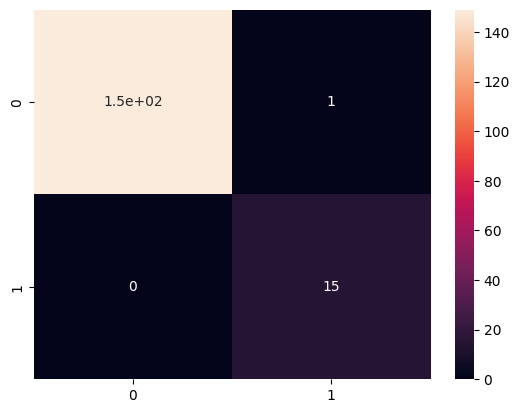

<Figure size 640x480 with 0 Axes>

In [72]:
print("confusion matrix: ")
print(confusion_matrix(y_pred_svc,y_test))
cm = confusion_matrix(y_pred_svc,y_test)
sns.heatmap(cm,annot=True)
plt.show()
plt.savefig('svm_confusion_matrix_heatmap.jpg')

    The above heatmap shows the confusion matrix of the first model buillt with the Support Vector Machine algorithm.
    The colormap on the side shows the difference in color ranging from the highest to the lowest value on the map.
    The first column represents the True positive value(Tp). This value is a measure of how many positive values were correctly predicted by the model.
    The second column is a measure of false Negative values. This value measures the number of wrong predictions or negative predictions that were predicted as positives. 
    The third is the false positives. This measures the wrongly predicted positive values.
    The last one is the True negative value which measures the correctly predicted negative values.
    As shown in the diagram The False positive and False negative values are higher and signifies a very good and accurate model meaning it has a high accuracy.

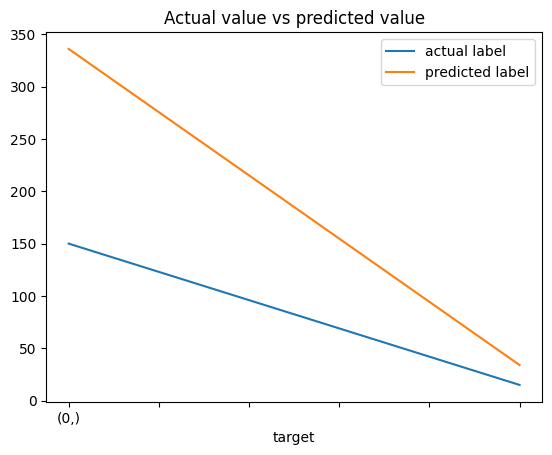

In [73]:
y_pred_svc = pd.DataFrame(y_pred_svc)
y_pred_svc.value_counts().plot(label='actual label')
pd.DataFrame(y_train).value_counts().plot(label='predicted label', title = 'Actual value vs predicted value')
plt.legend()
plt.savefig('rf_comparison.jpg')

    The graph above shows the actual value plot against the predicted value.
    As shown above, it is clear that the two lines follow the same trend.
    A legend showing the color label is shown on the graph.

#### Using K-Fold
        Stratified K-Fold 

In [74]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
skfold=StratifiedKFold(n_splits=10)
model=SVC()
scores=cross_val_score(model_svc,x_test,y_test,cv=skfold)
print('scores: ',scores)
print('Average/ Mean score: ', np.mean(scores))

scores:  [1.         0.94117647 1.         0.94117647 0.94117647 0.9375
 0.9375     1.         1.         0.9375    ]
Average/ Mean score:  0.9636029411764706


#### Plotting the ROC curve

In [75]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)

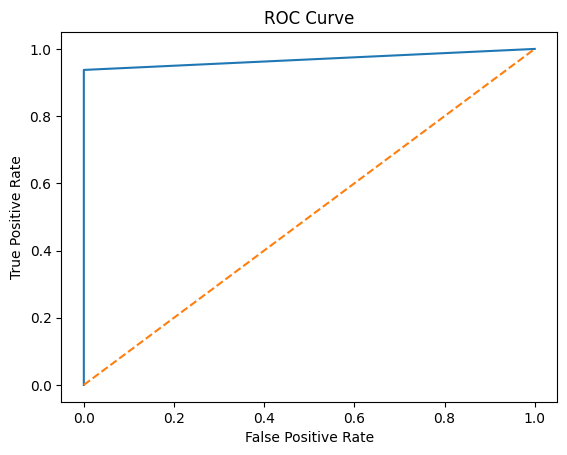

<Figure size 640x480 with 0 Axes>

In [76]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
plt.savefig('svm_roc.jpg')

    The Receiver Operating Characteristic (ROC) curve is a graphical representation commonly used to evaluate the performance of binary classification models. It illustrates the trade-off between the true positive rate (sensitivity or recall) and the false positive rate as the classification threshold varies. The ROC curve helps you assess the model's ability to distinguish between the positive and negative classes at different thresholds and aids in selecting an optimal threshold for making predictions.

    As shown in the chart the curve is closer to the top left corner showing us that the model can clearly distinguish between positive and negative values.

    - The diagonal line from bottom-left to top-right represents random guessing, and any point above this line is considered better than random.
    - The closer the AUC-ROC value is to 1, the better the model's ability to discriminate between classes.

### RandomForest

In [77]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [78]:
y_pred_rf = model_rf.predict(x_test)
y_pred_rf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [79]:
print("accuracy:\n  {}".format(accuracy_score(y_pred_rf,y_test)))
print("\n")
print("classification report:\n {}".format(classification_report(y_pred_rf,y_test)))

accuracy:
  0.9818181818181818


classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       152
           1       0.81      1.00      0.90        13

    accuracy                           0.98       165
   macro avg       0.91      0.99      0.94       165
weighted avg       0.99      0.98      0.98       165



    An accuracy of 98.18% is acheived with the RandomForest model

confusion matrix: 
[[149   3]
 [  0  13]]


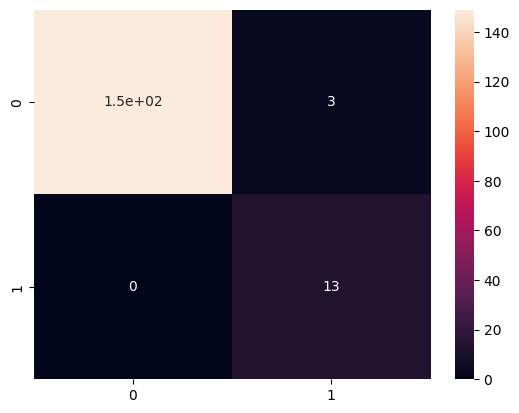

<Figure size 640x480 with 0 Axes>

In [80]:
print("confusion matrix: ")
print(confusion_matrix(y_pred_rf,y_test))
cm = confusion_matrix(y_pred_rf,y_test)
sns.heatmap(cm,annot=True)
plt.show()
plt.savefig('random_forest_confusion_matrix_heatmap.jpg')

    As shown in the above graph, the false positive value is 0 with the False negative value being 3. 
    This is showing that the model is performing well cos the lower the false values, the higher the true values and the better the accuracy of the model.

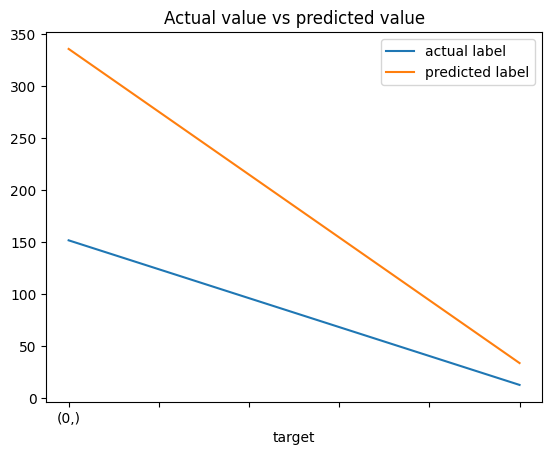

In [81]:
y_pred_svc = pd.DataFrame(y_pred_rf)
y_pred_svc.value_counts().plot(label='actual label')
pd.DataFrame(y_train).value_counts().plot(label='predicted label', title = 'Actual value vs predicted value')
plt.legend()
plt.savefig('rf_comparison.jpg')

    The graph above shows the actual value plot against the predicted value.
    As shown above, it is clear that the two lines follow the same trend.
    A legend showing the color label is shown on the graph.

#### Using K-Fold Cross Validation

In [82]:
from sklearn.model_selection import KFold
model=RandomForestClassifier()
kfold_validation=KFold(10)
from sklearn.model_selection import cross_val_score
results=cross_val_score(model_rf,x_test,y_test,cv=kfold_validation)
print('Scores: ',results)
print('Average score: ', np.mean(results))

Scores:  [1.         1.         0.94117647 1.         1.         0.875
 0.9375     0.9375     0.9375     1.        ]
Average score:  0.9628676470588236


#### Plotting the ROC curve

In [83]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

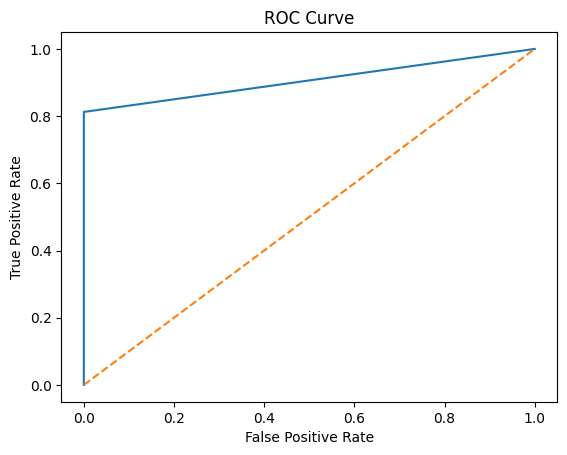

<Figure size 640x480 with 0 Axes>

In [84]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
plt.savefig('random_forest_roc.jpg')

    As shown above the curve is slightly different from the previous one we had.
    This is slightly lower than the previous model showing it's accuracy is a bit lower than the previous model's accuracy.